### This tutorial aims to give a example of unconditional generation of FCPFlow

If you are just starting to learn the FCPFlow model, I recommend reading the tutorial conditioning.ipynb first.

We use GE dataset for this simple experiment

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alg.tools as tl
import alg.models_fcpflow_lin as fcpf
import torch

C:\Users\weijiexia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


*load the data*

In [2]:
path = r'data\ge_data_ind.csv'
df = pd.read_csv(path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df_train = df.iloc[:100,:]
# creaste a column of ones has same length as the number of rows in the training data
ones = np.ones((df_train.shape[0],1))
# concatenate the column of ones to the training data
df_train = np.concatenate((df_train.values, ones ), axis=1)
df_train = pd.DataFrame(df_train, columns = df.columns.tolist() + ['ones'])
df_train.head()

,1,2,3,4,5,6,7,8,9,10,...,88,89,90,91,92,93,94,95,96,ones
0,0.028,0.040,0.030,0.042,0.035,0.026,0.019,0.020,0.020,0.020,...,0.173,0.160,0.150,0.103,0.184,0.373,0.112,0.100,0.080,1.0
1,0.190,0.180,0.190,0.168,0.160,0.140,0.130,0.118,0.089,0.058,...,0.160,0.172,0.253,0.270,0.270,0.272,0.268,0.230,0.330,1.0
2,0.174,0.156,0.140,0.159,0.125,0.131,0.064,0.051,0.055,0.049,...,0.225,0.345,0.301,0.224,0.210,0.188,0.187,0.186,0.189,1.0
3,0.120,0.120,0.113,0.117,0.120,0.123,0.140,0.150,0.130,0.117,...,0.195,0.175,0.150,0.152,0.155,0.153,0.150,0.150,0.147,1.0
4,0.110,0.132,0.115,0.123,0.128,0.101,0.101,0.064,0.030,0.030,...,0.083,0.138,0.122,0.120,0.140,0.138,0.160,0.194,0.164,1.0


*print original load profile*

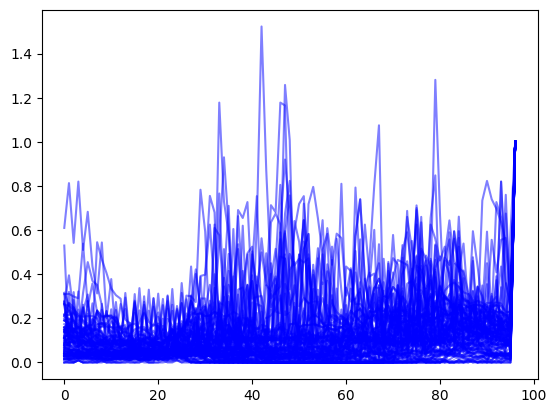

In [3]:
# create the data loader
dataLoader, scaler = tl.create_data_loader(df_train.values, batch_size=df_train.shape[0], shuffle=True) # I'm too lazy to wait, so I secretly load all the data once
data_plot = torch.tensor(scaler.transform(df_train.values[:,:]))

# plot the real data, the y-axis is the value of the feature, the x-axis is the time, the color of profile indicates the total daily energy consumption
tl.plot_figure(data_plot, scaler, 0) 

# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

*Train the model*

c:\Users\weijiexia\OneDrive - Delft University of Technology\Align4Energy\paper2\Github\Full-Convolutional-Time-Series-Flow\alg\models_fcpflow_lin.py:52: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2432.)
  w_init = torch.qr(torch.randn(num_channels, num_channels))[0]


0 loss:  96.14049466827547


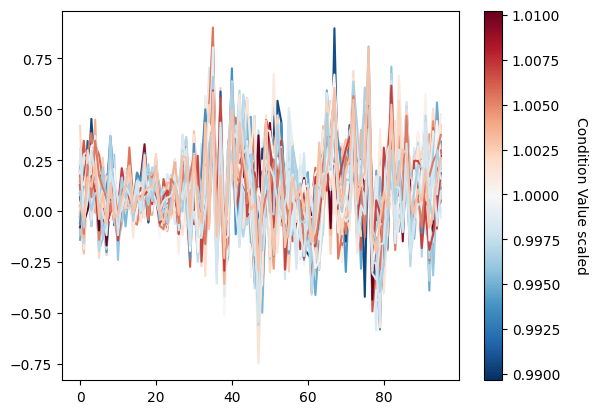

Energy distance:  0.13087740193794137 MSE.A:  0.12512222647348914
1000 loss:  -356.1069208422746


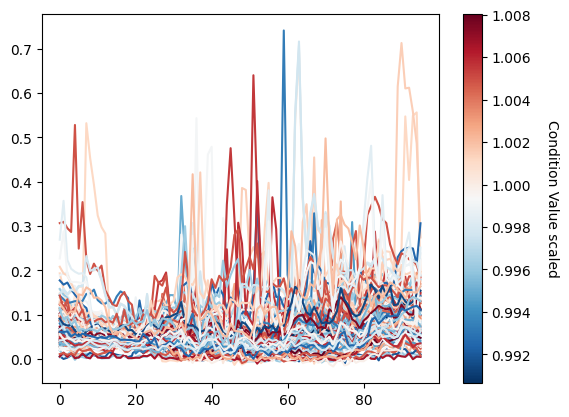

Energy distance:  0.07625575224938308 MSE.A:  0.05987253692225284
2000 loss:  -376.5877258900576


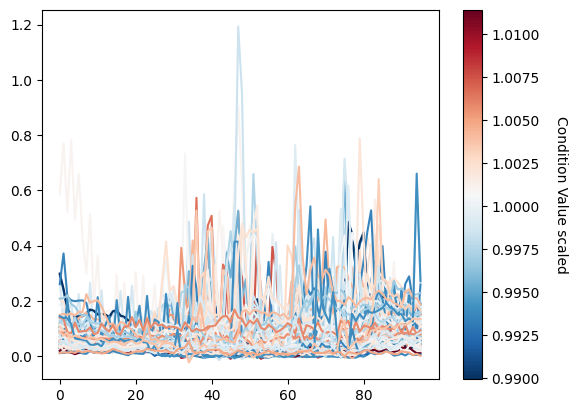

Energy distance:  0.04853766180232719 MSE.A:  0.02510256337221826
3000 loss:  -385.37827632570776


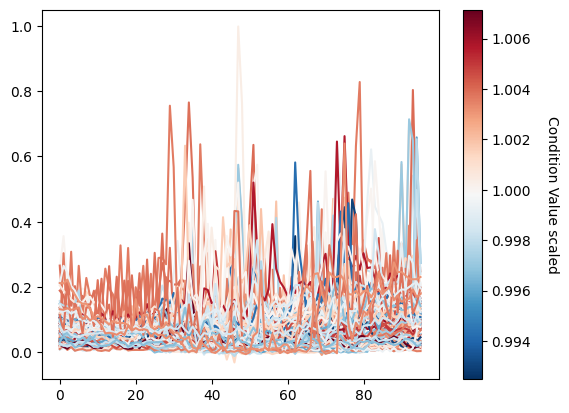

Energy distance:  0.05332620687928025 MSE.A:  0.03143097869831878
4000 loss:  -389.62598194725143


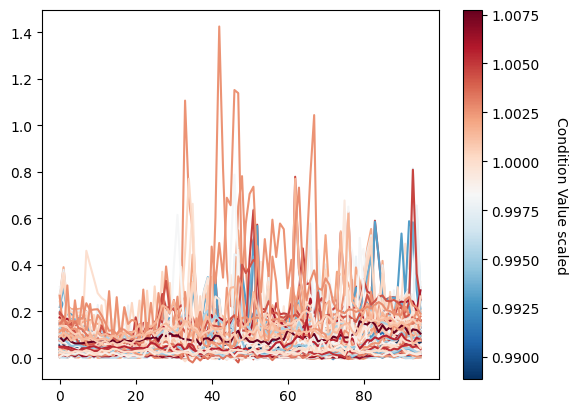

Energy distance:  0.036086215697750355 MSE.A:  0.03056517107097916
5000 loss:  -390.84018133314964


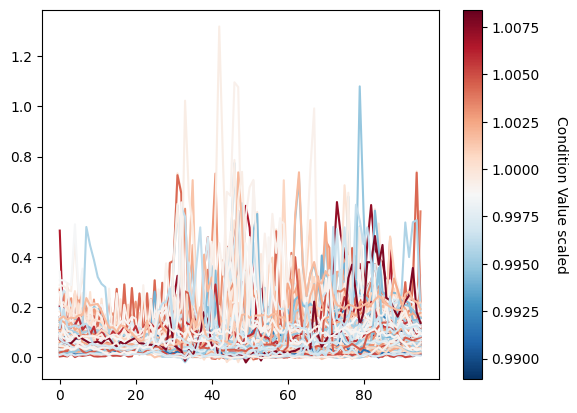

Energy distance:  0.030275851712020383 MSE.A:  0.009035097183960823
6000 loss:  -394.77880650016493


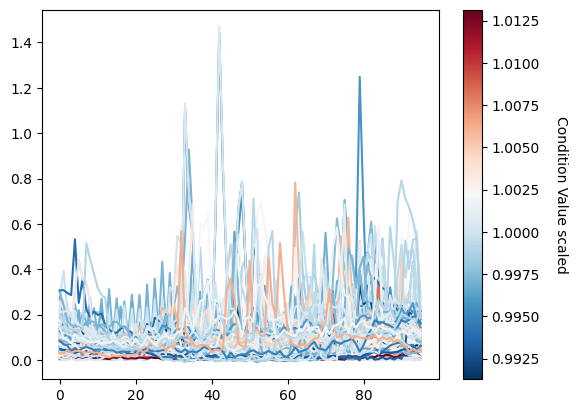

Energy distance:  0.0368107130152113 MSE.A:  0.007124956637077853
7000 loss:  -402.26118809042316


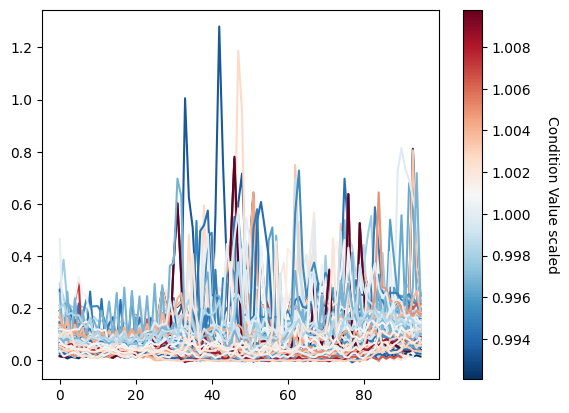

Energy distance:  0.03608993838020793 MSE.A:  0.012076785390379671


In [4]:
# Train the model
while True:
        
    # hyperparameters
    num_blocks = 4 # a small number of blocks for this small example, better not exceed 23 blocks due to numerical instability
    net_type = 'fullconv'  
    sfactor = 0.3 # scaling factor, 0.1 to 1 is a good range, larger value will lead to numerical instability, samller value limits the range of the output
    hidden_dim = 96*2 # hidden dimension of the s and t networks
    lr = 0.001 # check tools.oy with we defined a learning rate decay function
    w_decay = 0 # weight decay of the optimizer

    # define the model
    num_channels = 96 # resolution of the time series 
    condition_dim = 1  # ones column does not affect the output, so we set it to 1
    model = fcpf.FCPflow(num_blocks, num_channels, net_type, sfactor, hidden_dim, condition_dim)

    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)

    tl.train(model, dataLoader, optimizer, 20000, condition_dim, device, scaler, lr, test_set=None, pgap=1000)
    
    break # Opps, forgot to break the loop, in the expriment